In [51]:
#@title **Librerías Utilizadas**:

import tensorflow.keras as keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Add, Input, Reshape, Multiply
from keras.datasets import cifar10
from keras import optimizers, regularizers
from keras.models import Model
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from keras import backend as K
from keras.preprocessing.image import array_to_img
from IPython.display import Image
import tensorflow as tf

import cv2
from keras_preprocessing.image import img_to_array
from IPython.display import Image, display
import matplotlib.cm as cm
from keras.applications.imagenet_utils import preprocess_input

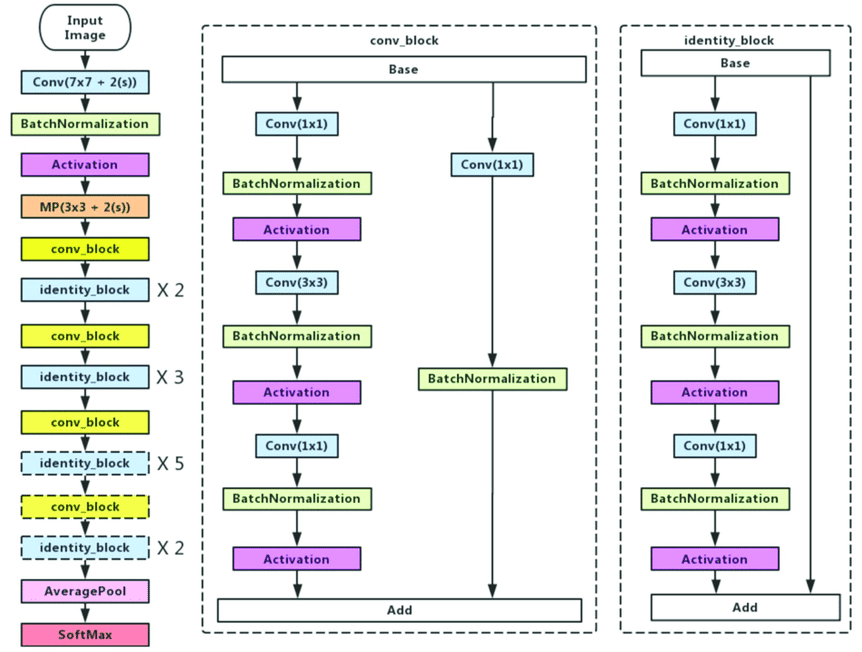

In [5]:
#@title **Bloques Arquitectura ResNet50:**

Image(filename='/content/ARQResNet50.png', width=700) 

In [38]:
#@title **Crear la capa de bloque inicial:**
# Dada la baja resolución de las imagenes en Cifar 10 vamos a usar stride 1 en vez de 2 
# como sugerido en Resnet original

def initial_conv(Input, filters, stride = 1, kz=7):

  x = Conv2D(filters, kernel_size=(kz,kz), strides=(stride, stride), 
             padding='same', use_bias=False, kernel_initializer='he_normal', 
             kernel_regularizer=l2(1e-4))(Input)
  
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [39]:
#@title **Definir bloque conv_block:**

def conv_block (Input, filters, stride=1):

  # Bloque para contraer a 1x1
  x = Conv2D(filters, kernel_size=(1,1), strides=(stride,stride),
             padding='same', use_bias=False, kernel_initializer='he_normal')(Input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Bloque para reservar convolucion a 3x3
  x = Conv2D(filters, kernel_size=(3,3), strides=(stride,stride),
             padding='same', use_bias=False, kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Bloque para expandir a 1x1 - Deja del mismo tamaño de la entrada
  x = Conv2D(filters*4, kernel_size=(1,1), strides=(stride,stride),
             padding='same', use_bias=False, kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Bloque skip
  skip_conv = Conv2D(filters*4, kernel_size=(1,1), strides=(stride,stride),
             padding='same', use_bias=False, kernel_initializer='he_normal')(Input)
  skip = BatchNormalization()(skip_conv)

  # sumamos los bloques

  x = Add() ([x, skip])

  return x

In [40]:
#@title **Definir bloque identidad:**

def ident_block (Input, filters, stride=1):

  x = Conv2D(filters, kernel_size=(1,1), strides=(stride,stride),
             padding='same', use_bias=False, kernel_initializer='he_normal')(Input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Bloque para reservar convolucion a 3x3
  x = Conv2D(filters, kernel_size=(3,3), strides=(stride,stride),
             padding='same', use_bias=False, kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Bloque para expandir a 1x1 - Deja del mismo tamaño de la entrada
  x = Conv2D(filters*4, kernel_size=(1,1), strides=(stride,stride),
             padding='same', use_bias=False, kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Sumando con la entrada
  
  x= Add ()([x,Input])

  return x

In [41]:
#@title **Crear la ResNet50:**

def build_resnet50 (h,w,n_outputs,r1,r2,r3,r4, first_conv_stride=1, first_conv_kernel_size=7):
  
  # Crear tensor de entrada a partir de la imagen
  inputs = Input (shape=(h, w, 3), name='image_input')

  # Bloque inicial
  x = initial_conv (inputs, 64, first_conv_stride, first_conv_kernel_size)
  x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)

  # Bloque de convolución 1
  x = conv_block(x, 64, 1)
  x = Activation('relu')(x)

  # Bloque de identidad r1

  for i in range(r1-1):
    x = ident_block(x, 64, 1)
    x = Activation('relu')(x)

  # Bloque de convolución 2
  x = conv_block(x, 128, 1)
  x = Activation('relu')(x)

  # Bloque de identidad r2
  for i in range(r2-1):
    x = ident_block(x, 128, 1)
    x = Activation('relu')(x)

  # Bloque de convolución 3
  x = conv_block(x, 256, 1)
  x = Activation('relu')(x)

  # Bloque de identidad r3
  for i in range(r3-1):
    x = ident_block(x, 256, 1)
    x = Activation('relu')(x)

 # Bloque de convolución 4
  x = conv_block(x, 512, 1)
  x = Activation('relu')(x)

  # Bloque de identidad r4
  for i in range(r4-1):
    x = ident_block(x, 512, 1)
    x = Activation('relu')(x)

  shape = K.int_shape(x)

  x = AveragePooling2D(pool_size=([shape[1], shape[2]]), strides=(1,1))(x)
  x = Flatten()(x)
  x = Dense(n_outputs, activation='softmax')(x)

  model = Model(inputs=inputs, outputs= x)

  return model

In [42]:
#@title **Entrenar Modelo Resnet50:**

model1 = build_resnet50(32,32,10,3,4,6,3,1,7)

In [43]:
#@title **Cargar Variables del Dataset:**

(x_train, y_train), (x_test, y_test)=cifar10.load_data()

In [44]:
#@title **Arquitectura del modelo:**

model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_106 (Conv2D)            (None, 32, 32, 64)   9408        ['image_input[0][0]']            
                                                                                                  
 batch_normalization_106 (Batch  (None, 32, 32, 64)  256         ['conv2d_106[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_130 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_106[0

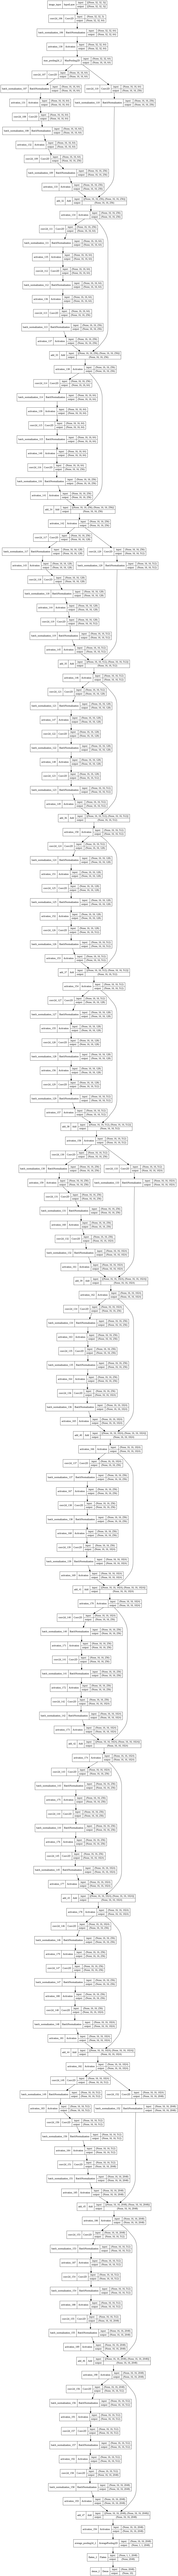

In [45]:
#@title **Gráfica Arquitectura:**

keras.utils.plot_model(model1,'Resnet_50.png', show_shapes=True, show_layer_names=True)

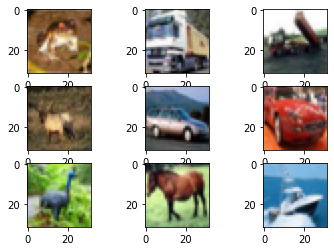

In [13]:
#@title **Visualizar los archivos:**

for i in range(0,9):
  plt.subplot(3,3,i+1)
  plt.imshow(array_to_img(x_train[i]))
plt.show()

In [14]:
#@title **Cambiar el tipo de dato a flotante, Normalización:**

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#z-score
mean =np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))

x_train = (x_train-mean)/(std + 1e-7)
x_test = (x_test-mean)/(std + 1e-7)

In [15]:
#@title **One hot encoding:**

num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [38]:
#@title **Entrenamiento:**

model1.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
batch_size = 64
epochs = 10

history = model1.fit(x_train, y_train, batch_size=batch_size,epochs=epochs, validation_data=(x_test, y_test), verbose=1)

model1.save("modelResNet50.h5")
model1.save_weights("modelResNet50wght.h5")
print("Modelo guardado en el PC")

Epoch 1/10
782/782 [==============================] - 1073s 1s/step - loss: 1.5135 - accuracy: 0.4654 - val_loss: 1.3655 - val_accuracy: 0.5101
Epoch 2/10
782/782 [==============================] - 1033s 1s/step - loss: 1.0333 - accuracy: 0.6348 - val_loss: 1.3227 - val_accuracy: 0.5814
Epoch 3/10
782/782 [==============================] - 1031s 1s/step - loss: 0.8279 - accuracy: 0.7128 - val_loss: 0.9511 - val_accuracy: 0.6778
Epoch 4/10
782/782 [==============================] - 1029s 1s/step - loss: 0.6911 - accuracy: 0.7644 - val_loss: 0.9919 - val_accuracy: 0.6698
Epoch 5/10
782/782 [==============================] - 1028s 1s/step - loss: 0.5990 - accuracy: 0.7966 - val_loss: 7.5519 - val_accuracy: 0.3318
Epoch 6/10
782/782 [==============================] - 1028s 1s/step - loss: 0.5237 - accuracy: 0.8205 - val_loss: 1.0370 - val_accuracy: 0.6673
Epoch 7/10
782/782 [==============================] - 1023s 1s/step - loss: 0.4601 - accuracy: 0.8432 - val_loss: 1.3960 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Modelo guardado en el PC


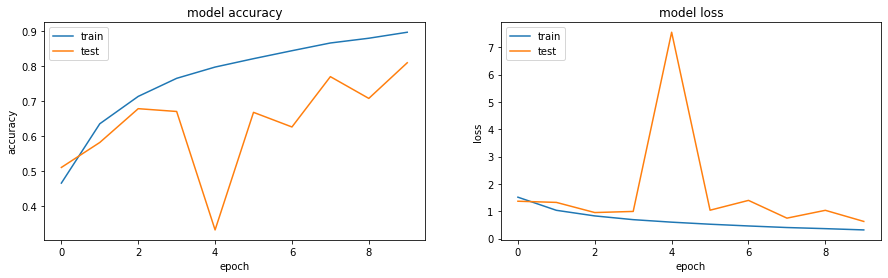

In [39]:
#@title **Graficar Accuracy y loss:**

### Gráfica de Accuracy
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

### Gráfica loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
#@title **Algortimo de GradCAM para visualización:**
#Author: fchollet
#Libro: Deep Learning with Python (2017)
#Description: How to obtain a class activation heatmap for an image classification model.

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [53]:
#@title **Cargar modelo:**

#model1 = keras.models.load_model('modelResNet50.h5')
model1.load_weights('modelResNet50.h5')


horse


<function matplotlib.pyplot.show>

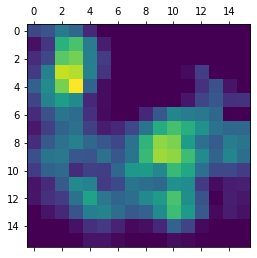

In [54]:
#@title **Etiquetas CIFAR10:**

etiquetas = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

img_array = preprocess_input(get_img_array('caballo1.jpg', size=(32,32)))
img_array = img_array.astype('float32')/255.0
mean = np.mean(img_array, axis=(0,1,2,3))
std = np.std(img_array, axis=(0,1,2,3))
img_array = (img_array - mean)/(std+1e-7)
preds1 = model1.predict(img_array)
#preds2 = model2.predict(img_array)

print(str(etiquetas[(np.argmax(preds1,axis=1))[0]]))
#print(str(etiquetas[(np.argmax(preds2,axis=1))[0]]))

heatmap1 = make_gradcam_heatmap(img_array, model1, 'activation_194')
#heatmap2 = make_gradcam_heatmap(img_array, model2, 'activation_97')

plt.matshow(heatmap1)
plt.show
#print()
#plt.matshow(heatmap2)
#plt.show

In [55]:
#@title **Porcentajes de valores:**

def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):

    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

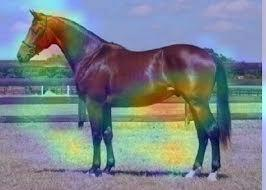

In [57]:
#@title **Resultado valores Gradcam:**

save_and_display_gradcam('caballo1.jpg', heatmap1, 'caballo1_RN50.jpg')